In [1]:

import numpy as np
from obspy.core.trace import Trace
from matplotlib import pyplot as plt
import time
import os 
import utilities.paper_cwt as paper_cwt
from utilities.cwt import *


Add notes on data 

### Load data from paper implementation. 

windows have shape (286, 15000): 286 channels and 5 minute window length. Windows overlap by 2.5 minutes so 7500 samples. 

In [2]:
#load data with shape (nchannels, nSamples)
window_one = np.load("./TestData/stanford_numpy/2016-09-02_23:59:54training_prep.npy")
window_two =np.load("./TestData/stanford_numpy/2016-09-03_00:01:54training_prep.npy")

print("data shape: ", window_one.shape)

data = np.concatenate([window_one, window_two], axis=1, dtype=np.float64)
print(data.shape)


data shape:  (286, 15000)
(286, 30000)


### Parameter for CWT that will be used later 

window_size: the length of the cwt window in seconds

n_channels: the number of channels in the data 

n_samples: the total samples in the data

n_features: number of features per sample after performing cwt 30 will be on the time axis 30 will be on the spacial axis

samples_per_second: samples taken per second at each channel

samples_within_average: the amount of cwt features that will be average per set in the final output

n_sub_samples: n_samples/samples_within_average amount of samples that will be in the final output

delta: 1/samples_per_second or the sample period 

freq_min: min frequency allowed through bandpass filter 

freq_max: max frequency allowed through bandpass filter

freq_min_space: min frequency used for the spatial scales of cwt 

freq_max_space: max frequency used for spatial scales of cwt

time_scales: scales for time cwt 

spatial_scales: scales for spatial cwt



In [3]:
window_size = 300
n_channels = data.shape[0]
n_samples = data.shape[1]
n_features = 60
samples_per_second = 50
samples_within_average = 25
n_sub_samples = int(n_samples / samples_within_average)
delta = 1.0 / float(samples_per_second)
freq_min = 0.2
freq_max = 24.0
freq_min_space= 0.04
freq_max_space= 2
w0 =8

time_log = np.logspace(np.log10(freq_min), np.log10(freq_max), 30)
space_log = np.logspace(np.log10(freq_min_space), np.log10(freq_max_space), 30)

dj=.5

s0 = (2*delta* (w0 + np.sqrt(2 + w0))) / (4 *np.pi)
J = np.ceil((1/dj )* np.log2((n_samples) / s0))
print(J)
scales = s0 * 2**(np.arange(J) *dj)
print(len(scales))

time_scales = paper_cwt.scales_from_fourier(time_log, wf="morlet", w0=8)
spatial_scales = paper_cwt.scales_from_fourier(space_log, wf="morlet", w0=8)
print(n_channels)
print(n_samples)
save_cwt_info(data.shape, samples_per_second, samples_within_average, space_log, time_scales, freq_min, freq_max, w0, start_window= 0, end_window=1200, window_length=300, subsampling=True, start_file="file", end_file="lastfile", filename="cwtinfo")

40.0
40
286
30000


In [4]:
#scales = (time_log*(w0 + np.sqrt(2 + w0**2)))/ (4 * np.pi)
scales

array([3.55306333e-02, 5.02479035e-02, 7.10612666e-02, 1.00495807e-01,
       1.42122533e-01, 2.00991614e-01, 2.84245067e-01, 4.01983228e-01,
       5.68490133e-01, 8.03966456e-01, 1.13698027e+00, 1.60793291e+00,
       2.27396053e+00, 3.21586582e+00, 4.54792106e+00, 6.43173165e+00,
       9.09584213e+00, 1.28634633e+01, 1.81916843e+01, 2.57269266e+01,
       3.63833685e+01, 5.14538532e+01, 7.27667370e+01, 1.02907706e+02,
       1.45533474e+02, 2.05815413e+02, 2.91066948e+02, 4.11630826e+02,
       5.82133896e+02, 8.23261651e+02, 1.16426779e+03, 1.64652330e+03,
       2.32853558e+03, 3.29304660e+03, 4.65707117e+03, 6.58609321e+03,
       9.31414234e+03, 1.31721864e+04, 1.86282847e+04, 2.63443728e+04])

### Perform cwt on two windows of data 

In [5]:
dir = "./TestData/stanford_numpy"
file_list = os.listdir(dir)
sorted_list = sorted(file_list)
sorted_list = sorted_list[1:]
print(sorted_list)

scales = (time_log*(w0 + np.sqrt(2 + w0**2)))/ (4 * np.pi)

count = 1
for file in sorted_list:
    data = np.load(dir+ "/"+ file)
    result = transform_window(data, n_channels, samples_per_second, samples_within_average, space_log, scales)
    
    filename = file.split(".")[0]
    np.save("cwt_" + filename, result)
    if(count == 2):
        break
    else:
        count+=1

['2016-09-02_23:59:54training_prep.npy', '2016-09-03_00:01:54training_prep.npy']


/Users/samgende/Documents/Bachelor/DAS-Unsupervised-Noise-Filtering/Code/utilities/cwt.py:60: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  multiplied = wavelet.T * fft_signal[None,:,:]


torch.Size([286, 14999, 60])
torch.Size([286, 14999, 60])


In [6]:

result = np.load("cwt_2016-09-02_23:59:54training_prep.npy")
result_2 = np.load("cwt_2016-09-03_00:01:54training_prep.npy")
result = np.concatenate((result, result_2), axis=1)
print(result.shape)



(286, 600, 60)


Normalize data by removing mean and scale variance to 1

In [7]:

#Do normilization 
trainingData = np.abs(result)
print(f'shape of data before normalization reshape {trainingData.shape}')
trainingData = np.reshape(trainingData, (n_channels * trainingData.shape[1], -1))
print(f'shape after rshape {trainingData.shape}')

#does the same thing as the papers sklearn 
trainingData = (trainingData - np.mean(trainingData, axis=0, keepdims=True)) / np.std(trainingData, axis=0, keepdims=True)
normed_data = trainingData.reshape(n_channels, result.shape[1], result.shape[2])
print(f'final shape {normed_data.shape}')

shape of data before normalization reshape (286, 600, 60)
shape after rshape (171600, 60)
final shape (286, 600, 60)


In [8]:
#calculate the scales for graphs 

minFrq = 0.5
maxFrq = 24
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
nf = 30
# logspace from paper implemenation 
ftime = np.logspace(np.log10(minFrq), np.log10(maxFrq), nf)
fspace = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), nf)

wf = "morlet"
w0 = 8

#scales from paper implementation 
time_scales = paper_cwt.scales_from_fourier(ftime, wf , w0)
scalesSpace = paper_cwt.scales_from_fourier(fspace, wf, w0)


#are these pseudo frequencies ? 
time_fourier = paper_cwt.fourier_from_scales(time_scales, wf, w0)
space_fourier = paper_cwt.fourier_from_scales(scalesSpace, wf, w0)

(600, 30)


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_1642/391325428.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


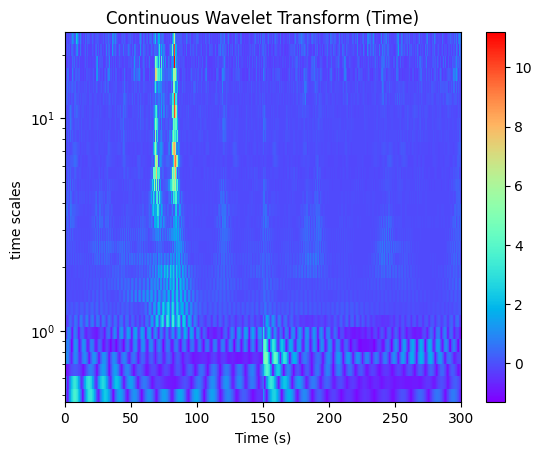

In [9]:

time_data = normed_data[127][:,:30]
print(time_data.shape)

time_graph = np.linspace(0, 300, 600)
fig, axs = plt.subplots(nrows=1, ncols=1)


pcm = axs.pcolormesh(time_graph, time_fourier[::-1], time_data.T, shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("time scales ")
axs.set_title("Continuous Wavelet Transform (Time)")
fig.colorbar(pcm, ax=axs)
fig.show()


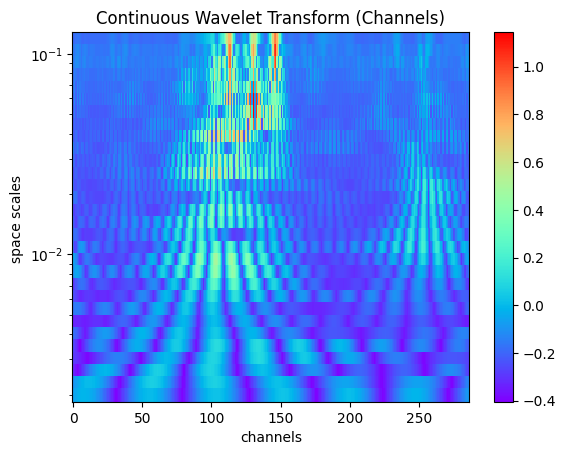

In [10]:
channels_data = normed_data[:,100,30:]

channels = np.linspace(0, 286, 286)
fig, axs = plt.subplots()
pcm = axs.pcolormesh(channels, space_fourier[::-1], channels_data.T,  shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("channels")
axs.set_ylabel("space scales ")
axs.set_title("Continuous Wavelet Transform (Channels)")
fig.colorbar(pcm, ax=axs)

In [11]:
def sub_sample(data):
    data =np.reshape(data[:, 250: 7750], (data.shape[0], 300, 25))
    return np.mean(data, axis=2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/obspy/signal/filter.py:62: UserWarning: Selected high corner frequency (24.0) of bandpass is at or above Nyquist (1.0). Applying a high-pass instead.
  warnings.warn(msg)


torch.Size([286, 299, 60])
torch.Size([286, 299, 60])


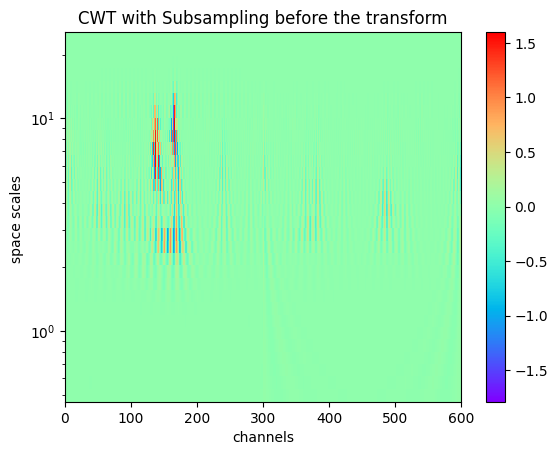

In [12]:
subsampled_data = sub_sample(window_one)
subsampled_data2 = sub_sample(window_two)

subsampled_transform = transform_window(subsampled_data, n_channels, 2, 1, space_log, time_scales, subsampling=False )
subsampled_transform2 = transform_window(subsampled_data2, n_channels, 2, 1,space_log, time_scales, subsampling=False)
subsampled_result = np.concatenate((subsampled_transform, subsampled_transform2), axis=1)
time= np.linspace(0, 600, 598)

fig, axs = plt.subplots()
pcm = axs.pcolormesh(time, time_fourier[::-1], subsampled_result[127,:,:30].T,  shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("channels")
axs.set_ylabel("space scales ")
axs.set_title("CWT with Subsampling before the transform")
fig.colorbar(pcm, ax=axs)

(14999,)


ValueError: x and y must have same first dimension, but have shapes (14999,) and (600,)

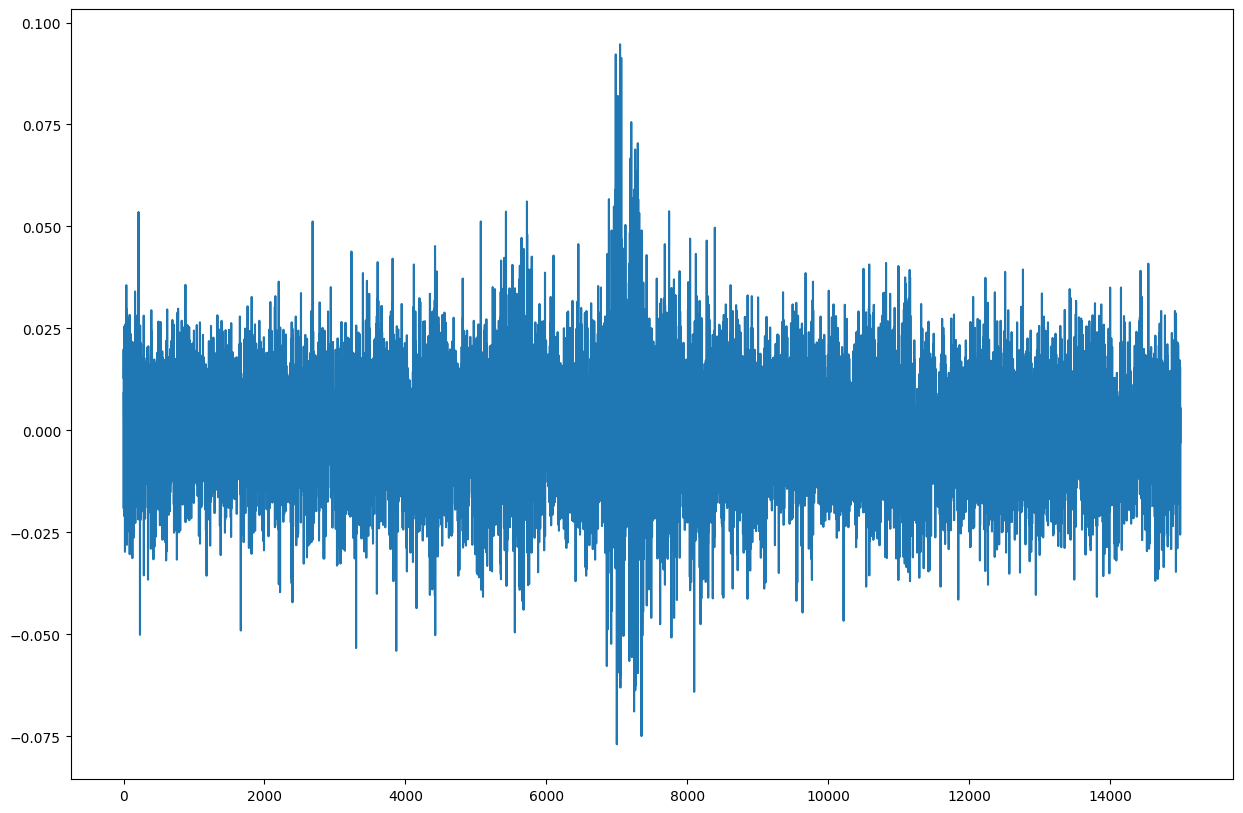

In [16]:
    #calculate the scales for cwt
#scales = (time_log*(w0 + np.sqrt(2 + w0**2)))/ (4 * np.pi)

diff = data[:-1] - data[1:]

o_signal = window_one[0]
o_signal = o_signal[1:] - o_signal[:-1]
o_signal -= np.mean(o_signal) 

#o_signal = sub_sample(o_signal[None, :])
#o_signal = np.squeeze(o_signal)

o_signal2 = window_two[0]
o_signal2 = o_signal2[1:] - o_signal2[:-1]
o_signal2 -= np.mean(o_signal2)
o_signal2 = sub_sample(o_signal2[None, :])
o_signal2 = np.squeeze(o_signal2)

#combo = np.abs(np.concatenate((o_signal, o_signal2)))
transform = result[0][:,:len(scales)]

reconstruction = inverse_cwt(transform.T, scales, dj=.5, dt=0.02, w0=w0)
print(o_signal.shape )
print(reconstruction.shape)

t = np.linspace(0, 14999, 14999)
plt.figure(figsize=(15,10))
plt.plot(t, o_signal, label="signal")
plt.plot(t, reconstruction, label="reconstruction", ls="--")
print(np.min(transform))
plt.legend()

